### Notebook for the training of the human PBMC data from TB with `scNym`.

- **Developed by**: Carlos Talavera-López
- **Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich**
- v221102

### Load required modules

In [1]:
import time
import scnym
import anndata
import scipy as sp
import numpy as np
import pandas as pd
import scanpy as sc

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.6.0
sinfo       0.3.4
-----
PIL                 9.2.0
absl                NA
asttokens           NA
backcall            0.2.0
certifi             2022.06.15
chardet             3.0.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
dunamai             1.12.0
entrypoints         0.4
executing           0.9.1
get_version         3.5.4
google              NA
h5py                3.7.0
idna          

In [3]:
config_name = "new_identity_discovery"
config = scnym.api.CONFIGS[config_name]
config["domain_groupby"] = "domain_label"

### Read in reference object

In [4]:
combined_object = sc.read_h5ad('/home/cartalop/data/single_cell/lung/tb/working_objects/CaiY_PBMC_TB_pre-scnym_ctl221103.h5ad')
combined_object

AnnData object with n_obs × n_vars = 319065 × 22792
    obs: 'object', 'domain_label', 'cell_states'
    var: 'gene_id-query'

In [5]:
sc.pp.filter_genes(combined_object, min_cells = 3)
sc.pp.filter_genes(combined_object, min_counts  = 10)
combined_object

filtered out 2474 genes that are detected in less than 3 cells
filtered out 119 genes that are detected in less than 10 counts


AnnData object with n_obs × n_vars = 319065 × 20199
    obs: 'object', 'domain_label', 'cell_states'
    var: 'gene_id-query', 'n_cells', 'n_counts'

In [6]:
combined_object.X[:8,:8].todense()

matrix([[0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         5.9510117, 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         6.3671494, 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       ]], dtype=float32)

In [7]:
sc.pp.normalize_total(combined_object, target_sum = 1e6)
sc.pp.log1p(combined_object)

normalizing counts per cell
    finished (0:00:01)


### Filter low quality cells

In [8]:
sc.pp.filter_genes(combined_object, min_cells = 3)
sc.pp.filter_genes(combined_object, min_counts  = 10)
combined_object

AnnData object with n_obs × n_vars = 319065 × 20199
    obs: 'object', 'domain_label', 'cell_states'
    var: 'gene_id-query', 'n_cells', 'n_counts'
    uns: 'log1p'

### Train reference with `scNym`

- Record start time for `scNym` training

In [9]:
start_time = time.time()

- Train model

In [10]:
scnym.api.scnym_api(
    adata = combined_object,
    task = 'train',
    groupby = 'cell_states',
    domain_groupby='domain_label',
    out_path = '/home/cartalop/data/single_cell/lung/tb/models/scnym_model_fine/',
    config = 'new_identity_discovery',
)

CUDA compute device found.
145381 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (173684, 20199)
target   examples:  (145381, 20199)
X:  (173684, 20199)
y:  (173684,)
Using user provided domain labels.
Found 35 source domains and 19 target domains.
Not weighting classes and not balancing classes.
Found 54 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
>>>>> 61/99|------------------____________|
Early stopping at epoch 61
>>>>>
Training complete.

Evaluating model.
EVAL LOSS:  0.5398061525295762
EVAL ACC :  0.8807070067361391
Predictions | Labels
[[31 36]
 [13 13]
 [13 13]
 [29 29]
 [29 29]
 [28 28]
 [16 16]
 [28 28]
 [19 19]
 [13 13]

- Record end time for scNym label transfer

In [11]:
end_time = time.time()

- Compute the elapsed time

In [12]:
total_time = end_time - start_time
print(f"Total time: {total_time}")

Total time: 3128.003237247467


### Predict cell labels

In [13]:
from scnym.api import scnym_api

scnym_api(
    adata = combined_object,
    task = 'predict',
    key_added = 'scNym',
    trained_model = '/home/cartalop/data/single_cell/lung/tb/models/scnym_model_fine/',
    out_path = '/home/cartalop/data/single_cell/lung/tb/models/scnym_model_fine/',
    config = 'new_identity_discovery',
)


CUDA compute device found.


Finding cell types:   0%|          | 1/312 [00:00<00:44,  6.98it/s]

Loaded model predicting 42 classes from 20199 features
['AS-DC' 'B invar' 'B n-sw mem' 'B n-sw mem IFN stim' 'B naive'
 'B naive IFN stim' 'B sw mem' 'Baso/Eos' 'Cycling' 'HPC' 'HPC IFN stim'
 'ILC' 'MAIT' 'Monocyte CD14' 'Monocyte CD14 IFN stim' 'Monocyte CD14 IL6'
 'Monocyte CD16' 'Monocyte CD16 IFN stim' 'Monocyte CD16+C1' 'NK'
 'NK CD56' 'NK IFN stim' 'NKT' 'Plasma cells' 'Plasmablasts' 'Platelets'
 'RBC' 'T CD4 CTL' 'T CD4 helper' 'T CD4 naive' 'T CD4 naive IFN stim'
 'T CD8 CM' 'T CD8 CTL' 'T CD8 CTL IFN stim' 'T CD8 EM' 'T CD8 EMRA'
 'T CD8 naive' 'T g/d' 'T reg' 'cDC1' 'cDC2' 'pDC']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████| 312/312 [00:46<00:00,  6.74it/s]


Extracting model embeddings...


### Visualise label transfer and cofindence using `X_scNym`

computing neighbors


/home/cartalop/mambaforge/envs/scnym/lib/python3.8/site-packages/numba/core/typed_passes.py:313: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../mambaforge/envs/scnym/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/cartalop/mambaforge/envs/scnym/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics f

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:33)
computing UMAP


/home/cartalop/mambaforge/envs/scnym/lib/python3.8/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:07:29)


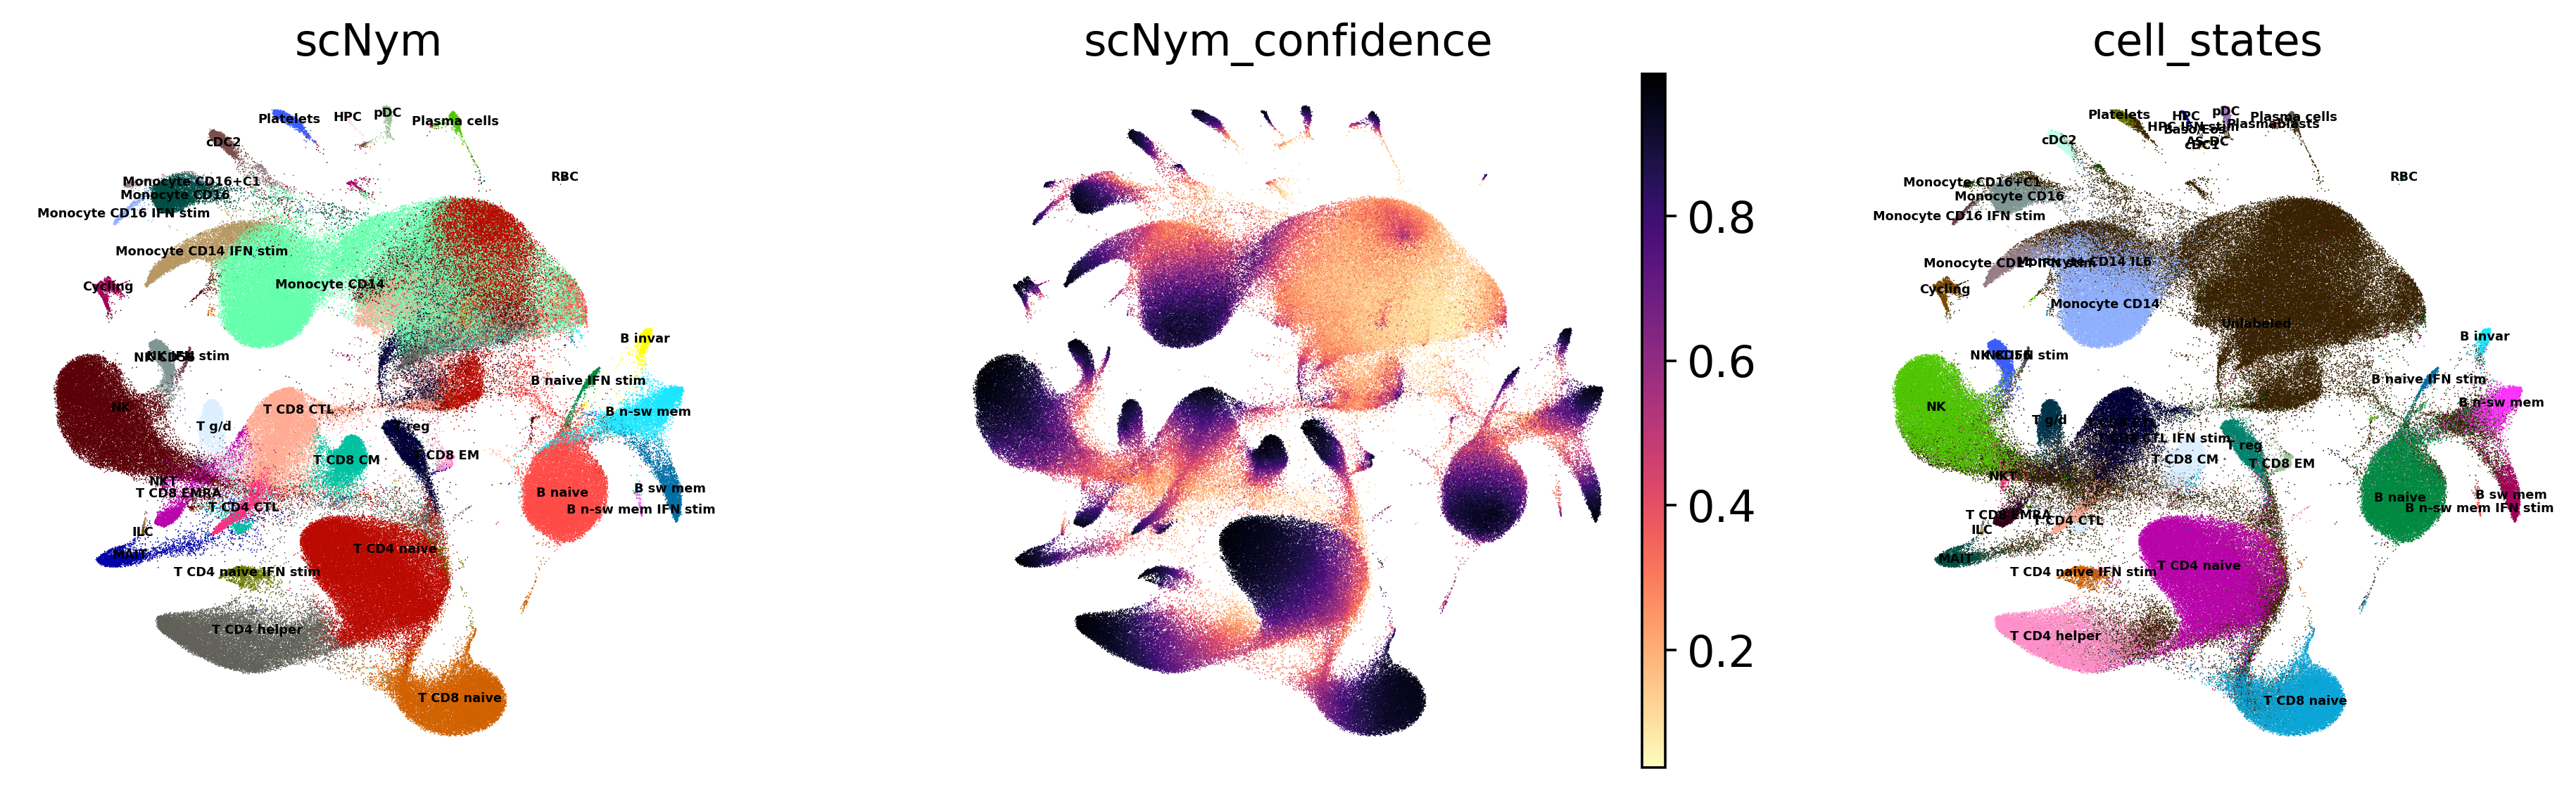

In [14]:
sc.pp.neighbors(combined_object, use_rep = 'X_scnym', n_neighbors = 50)
sc.tl.umap(combined_object, min_dist = 0.3, spread = 8, random_state = 1712)
sc.pl.umap(combined_object, color = ['scNym', 'scNym_confidence', 'cell_states'], size = 0.6, frameon = False, legend_loc = 'on data', legend_fontsize = 4)

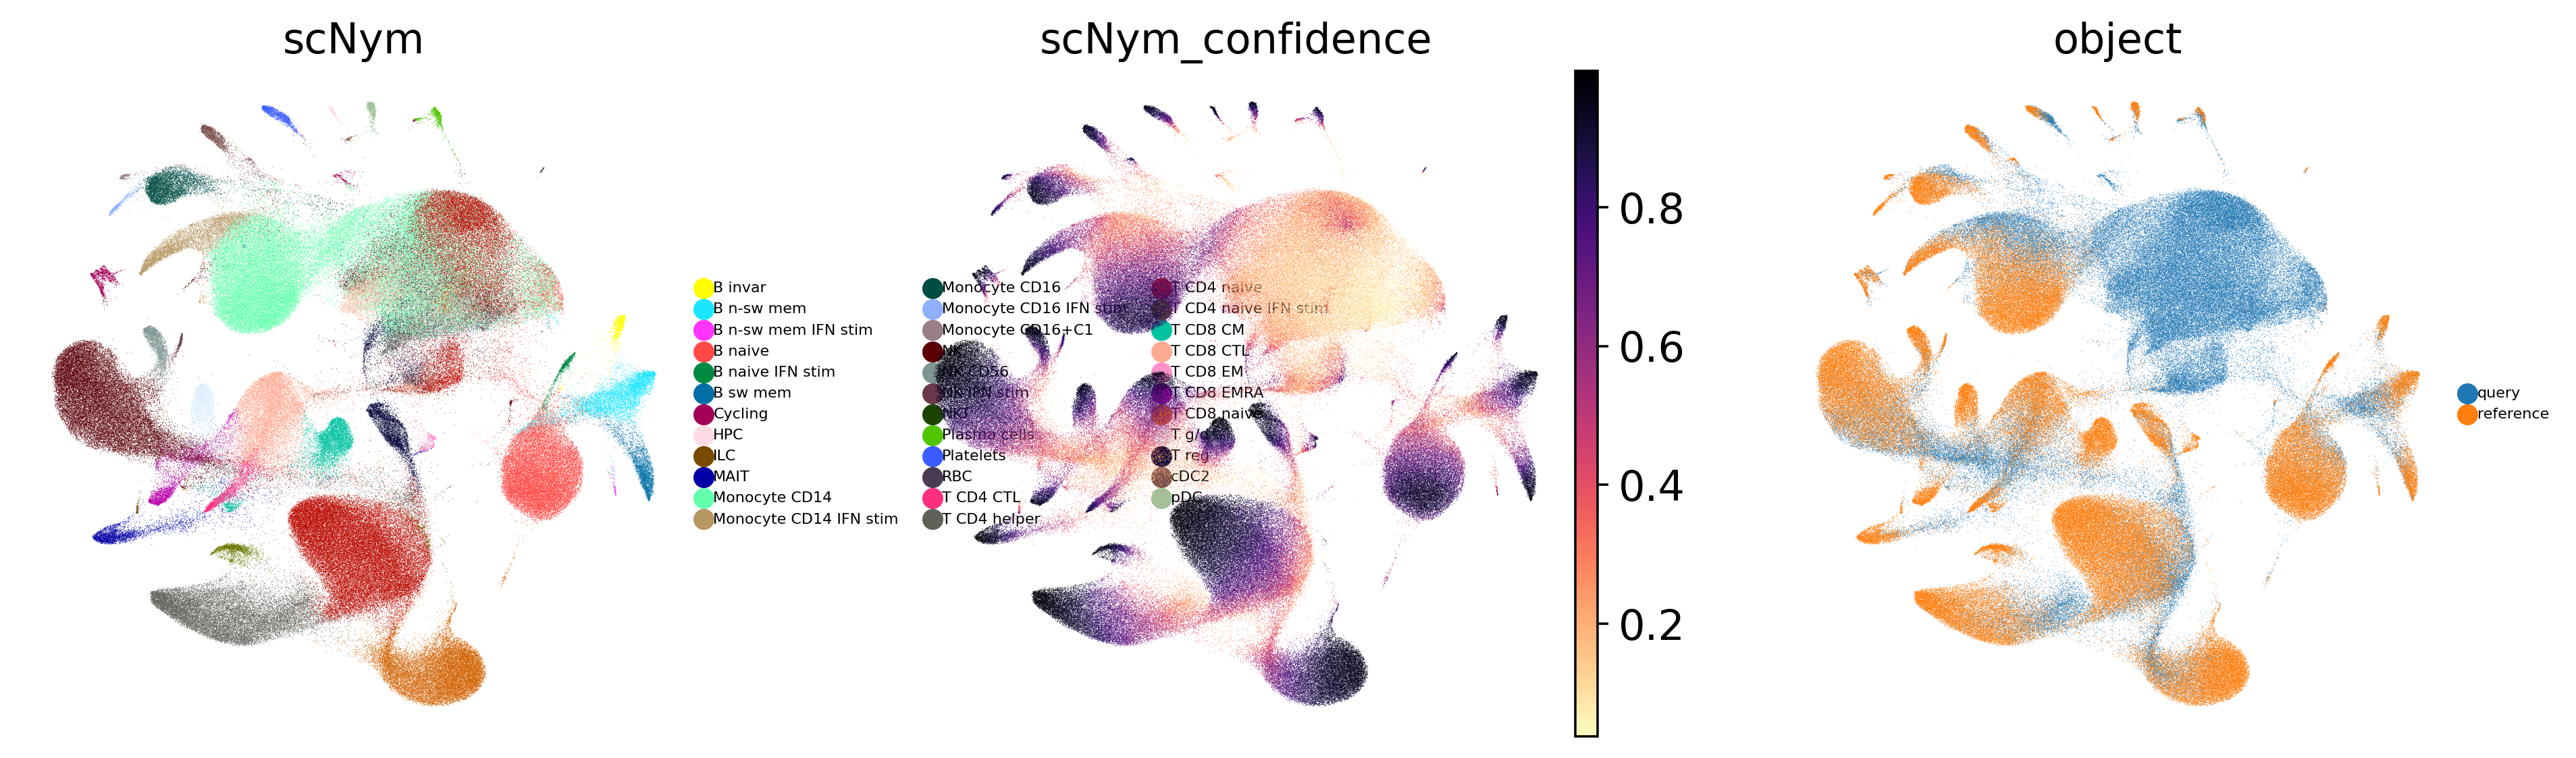

In [15]:
sc.pl.umap(combined_object, color = ['scNym', 'scNym_confidence', 'object'], size = 0.2, frameon = False, legend_fontsize = 5)

In [16]:
combined_object

AnnData object with n_obs × n_vars = 319065 × 20199
    obs: 'object', 'domain_label', 'cell_states', 'scNym', 'scNym_confidence'
    var: 'gene_id-query', 'n_cells', 'n_counts'
    uns: 'log1p', 'scNym_train_results', 'scNym_probabilities', 'neighbors', 'umap', 'scNym_colors', 'cell_states_colors', 'object_colors'
    obsm: 'X_scnym', 'X_umap'
    obsp: 'distances', 'connectivities'

### Save object

In [17]:
adata_export = anndata.AnnData(X = combined_object.X, obs = combined_object.obs, var = combined_object.var, uns = combined_object.uns, obsm = combined_object.obsm, obsp = combined_object.obsp)
adata_export

AnnData object with n_obs × n_vars = 319065 × 20199
    obs: 'object', 'domain_label', 'cell_states', 'scNym', 'scNym_confidence'
    var: 'gene_id-query', 'n_cells', 'n_counts'
    uns: 'log1p', 'scNym_train_results', 'scNym_probabilities', 'neighbors', 'umap', 'scNym_colors', 'cell_states_colors', 'object_colors'
    obsm: 'X_scnym', 'X_umap'
    obsp: 'distances', 'connectivities'

### Subset query only 

In [18]:
adata_query = adata_export[adata_export.obs['object'].isin(['query'])]
adata_query

View of AnnData object with n_obs × n_vars = 145381 × 20199
    obs: 'object', 'domain_label', 'cell_states', 'scNym', 'scNym_confidence'
    var: 'gene_id-query', 'n_cells', 'n_counts'
    uns: 'log1p', 'scNym_train_results', 'scNym_probabilities', 'neighbors', 'umap', 'scNym_colors', 'cell_states_colors', 'object_colors'
    obsm: 'X_scnym', 'X_umap'
    obsp: 'distances', 'connectivities'

In [19]:
adata_query.write('/home/cartalop/data/single_cell/lung/tb/working_objects/CaiY_PBMC_TB_post-scnym_ctl221103.h5ad')